## Описание алгоритма стохастического градиентного спуска с оптимизатором импульсов Нестерова (Nesterov Momentum)

Данный код реализует алгоритм стохастического градиентного спуска (SGD) с использованием мини-батчей и оптимизатора импульсов Нестерова (Nesterov Momentum) для аппроксимации функции:

$$f(x) = -0.7 \cdot x - 0.2 \cdot x^2 + 0.05 \cdot x^3 - 0.2 \cdot \cos(3x) + 2$$

на интервале $[-4, 6]$ моделью вида:

$$a(x) = w_0 + w_1 \cdot x + w_2 \cdot x^2 + w_3 \cdot x^3$$

**Цель:** Найти вектор параметров $w = [w_0, w_1, w_2, w_3]^T$, минимизирующий усеченный эмпирический риск $Q_k(w)$.

**Усеченный эмпирический риск:**

$$Q_k(w) = \frac{1}{K} \sum_{i=k}^{k+K-1} (a(x_i, w) - y_i)^2 = \frac{1}{K} \sum_{i=k}^{k+K-1} (w^T \cdot x_i - y_i)^2$$

где:
- $k$ - случайно выбранный начальный индекс мини-батча.
- $K$ - размер мини-батча.
- $a(x_i, w)$ - значение модели в точке $x_i$ с текущими параметрами $w$.
- $y_i$ - истинное значение функции в точке $x_i$.

**Алгоритм стохастического градиентного спуска с оптимизатором импульсов Нестерова:**

Nesterov Momentum (NAG) - это модификация обычного метода импульсов, которая помогает избежать "перелета" через минимум и потенциально ускоряет сходимость. Основная идея заключается в вычислении градиента не в текущей точке $w$, а в точке, куда, по предсказанию импульса, мы скоро попадем ($w - \gamma \cdot v$).

Правила обновления для вектора импульса $v$ и вектора параметров $w$:

1.  Вычисление вектора импульса с "заглядыванием вперед":
    $$v = \gamma \cdot v + (1-\gamma) \cdot \eta \cdot \frac{\partial Q_k(w - \gamma \cdot v)}{\partial w}$$
2.  Обновление вектора параметров:
    $$w_n = w_{n-1} - v$$

где:
- $w_n$ - вектор параметров на текущей итерации.
- $w_{n-1}$ - вектор параметров на предыдущей итерации.
- $v$ - вектор импульса.
- $\gamma$ - коэффициент момента Нестерова.
- $\eta$ - шаг обучения (learning rate).
- $\frac{\partial Q_k(w - \gamma \cdot v)}{\partial w}$ - градиент усеченного эмпирического риска, вычисленный в "промежуточной" точке $w - \gamma \cdot v$.

**Градиент усеченного эмпирического риска с учетом импульса Нестерова:**

Производная усеченного показателя качества по вектору параметров $w$ для мини-батча, вычисленная в точке $w - \gamma \cdot v$:

$$\frac{\partial Q_k(w - \gamma \cdot v)}{\partial w} = \frac{2}{K} \sum_{i=k}^{k+K-1} ((w - \gamma \cdot v)^T \cdot x_i - y_i) \cdot x_i^T$$

где $x_i = [1, x, x^2, x^3]^T$ - вектор признаков для i-го образа в мини-батче.

**Матрица признаков X:**

Матрица признаков $X$ для всей выборки формируется таким образом, что каждая строка соответствует одной точке данных $x_i$ из интервала $[-4, 6]$. Столбцы матрицы содержат значения признаков для каждой точки, а именно:

- Первый столбец: константа 1 (для члена $w_0$)
- Второй столбец: значение $x_i$
- Третий столбец: значение $x_i^2$
- Четвертый столбец: значение $x_i^3$

Таким образом, матрица $X$ имеет размерность $n \times 4$, где $n$ - количество точек в выборке.

**Скользящее среднее ошибки:**

Для отслеживания сходимости в процессе обучения используется экспоненциальное скользящее среднее ошибки. На каждой итерации, после вычисления ошибки $Q_k$ для текущего случайно выбранного мини-батча, скользящее среднее $Qe$ обновляется по формуле:

$$Qe_i = \lambda \cdot Q_{k_i} + (1 - \lambda) \cdot Qe_{i-1}$$

где:
- $Qe_i$ - текущее значение скользящего среднего ошибки.
- $Q_{k_i}$ - ошибка на текущей итерации для выбранного мини-батча.
- $\lambda$ (`lm` в коде) - параметр сглаживания.

**Реализация в коде (общие моменты):**

В коде для реализации этого алгоритма необходимо будет:

1.  Определить целевую функцию $f(x)$ и подготовить данные (пары $x_i, y_i$) на заданном интервале.
2.  Создать матрицу признаков $X$ для всей выборки.
3.  Инициализировать параметры $w$, шаг обучения $\eta$, коэффициент момента $\gamma$, начальное значение импульса $v$, размер мини-батча $K$ (`batch_size`), число итераций $N$, и параметр сглаживания $\lambda$ (`lm`).
4.  В цикле итераций:
    - Случайно выбрать начальный индекс `k` для мини-батча (`k = np.random.randint(0, sz-batch_size)`), где `sz` - размер выборки.
    - Извлечь мини-батчи признаков (`X_batch = X[k:k+batch_size]`) и истинных значений (`y_batch = coord_y[k:k+batch_size]`).
    - Вычислить "промежуточную" точку для градиента с учетом импульса Нестерова: $w_{ahead} = w - \gamma \cdot v$.
    - Вычислить градиент усеченного эмпирического риска в этой промежуточной точке: $\frac{\partial Q_k(w_{ahead})}{\partial w} = \frac{2}{K} \cdot X_{batch}^T \cdot (X_{batch} \cdot w_{ahead} - y_{batch})$.
    - Обновить вектор импульса $v$ с использованием этого градиента: $v = \gamma \cdot v + (1-\gamma) \cdot \eta \cdot \frac{\partial Q_k(w_{ahead})}{\partial w}$.
    - Обновить вектор параметров $w$ с использованием обновленного импульса $v$: $w = w - v$.
    - Вычислить ошибку на текущем мини-батче (`Qk = np.mean((X_batch @ w - y_batch)**2)`) и обновить скользящее среднее ошибки (`Qe = lm * Qk + (1 - lm) * Qe`).
5.  После завершения итераций:
    - Вычислить итоговое значение среднего эмпирического риска для всей выборки: $Q(a, X) = \frac{1}{n} \cdot \sum_{i=1}^{n} (a(x_i, w) - y_i)^2 = \frac{1}{n} \cdot (Xw - y)^T \cdot (Xw - y)$, где $y$ - вектор истинных значений для всей выборки.
    - Вывести итоговые параметры $w$, итоговую среднеквадратичную ошибку $Q$, и последнее значение скользящего среднего ошибки $Qe$.
    - (Опционально) Построить финальный график аппроксимации.

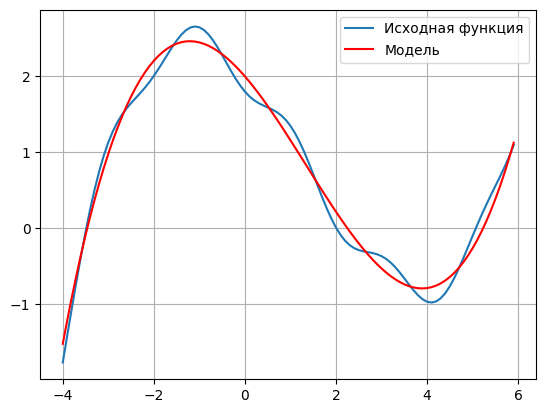

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# исходная функция, которую нужно аппроксимировать моделью a(x)
def func(x):
    return -0.7 * x - 0.2 * x ** 2 + 0.05 * x ** 3 - 0.2 * np.cos(3 * x) + 2


coord_x = np.arange(-4.0, 6.0, 0.1) # значения по оси абсцисс [-4; 6] с шагом 0.1
coord_y = func(coord_x) # значения функции по оси ординат
X = np.vstack((
    np.ones_like(coord_x),
    coord_x,
    coord_x**2,
    coord_x**3
)).T # Транспонируем, чтобы получить (sz, 4)

y = coord_y

sz = len(coord_x)  # количество значений функций (точек)
# w, lr, v - одномерные массивы (4,)
eta = np.array([0.1, 0.01, 0.001, 0.0001]) # шаг обучения для каждого параметра w0, w1, w2, w3
w = np.array([0., 0., 0., 0.]) # начальные значения параметров модели
N = 500 # число итераций алгоритма SGD
lm = 0.02 # значение параметра лямбда для вычисления скользящего экспоненциального среднего
batch_size = 20 # размер мини-батча (величина K = 20)
gamma = 0.8 # коэффициент гамма для вычисления импульсов Нестерова
v = np.zeros(len(w))  # начальное значение [0, 0, 0, 0]
Qe = np.mean((X @ w - y)**2)
np.random.seed(0) # генерация одинаковых последовательностей псевдослучайных чисел

for _ in range(N):
    k = np.random.randint(0, sz - batch_size - 1)
    X_batch = X[k : k + batch_size] # (K, 4)
    y_batch = y[k : k + batch_size] # (K,)
    Qk = np.mean((X_batch @ w - y_batch)**2)
    Qe = lm * Qk + (1 - lm) * Qe
    grad = (2 / batch_size) * (X_batch.T @ (X_batch @ (w - gamma * v) - y_batch))
    v = gamma * v + (1 - gamma) * (eta * grad)
    w = w - v

Q = np.mean((X @ w - y)**2)
# Код для отображения финального графика
fig, ax = plt.subplots()
ax.grid(True)
ax.plot(coord_x, coord_y, label='Исходная функция')
ax.plot(coord_x, X @ w, c="red", label='Модель')
ax.legend()
plt.show()